In [1]:
from itables import init_notebook_mode
import itables.options as opt

# Ativa o modo interativo
init_notebook_mode(all_interactive=True)

# 1. Botões de exportação
opt.buttons = ["copy", "csv", "excel", "pdf"]

# 2. Estilo CSS (display e nowrap ajudam na formatação)
opt.classes = ["display", "nowrap"]

# 3. CONFIGURAÇÃO DE SCROLL (O Segredo está aqui)
opt.scrollY = "400px"       # Define a altura fixa (cria scroll vertical se passar disto)
opt.scrollCollapse = True   # Se a tabela for pequena, ela encolhe (não fica com espaço branco)
opt.scrollX = True          # Cria scroll horizontal se houver muitas colunas
opt.paging = False          # Desliga a paginação para poderes fazer scroll infinito verticalmente
                            # (Se preferires páginas, muda para True, mas o scrollY continua a funcionar)

# Opcional: Definir largura da tabela para 100% ou um valor fixo
# opt.style = "width:100%"

from data.loader import load_complete_dataset
from data.preprocessing import add_module_columns
from config.constants import DEVICES
%load_ext autoreload
%autoreload 2

dataset = load_complete_dataset()
dataset = add_module_columns(dataset)

In [ ]:
import pandas as pd

def get_activity_distribution(df):
    # 1. Definição do Mapeamento (Dicionário)
    ACTIVITY_IDS = range(1, 17, 1)
    ACTIVITY_LABELS = [
        "Stand", "Sit", "Sit and Talk", "Walk", "Walk and Talk", 
        "Climb Stair (up/down)", "Climb Stair (up/down) and talk", "Stand-> Sit",
        "Sit-> Stand", "Stand-> Sit and talk", "Sit->Stand and talk", "Stand-> walk",
        "Walk-> stand", "Stand -> climb stairs", 
        "Climb stairs -> walk", "Climb stairs and talk -> walk and talk"
    ]
    # Cria dicionário: {1: "Stand", 2: "Sit", ...}
    label_map = dict(zip(ACTIVITY_IDS, ACTIVITY_LABELS))

    # 2. Encontrar a coluna correta
    df = df.copy()
    col_name = 'activity'
    if 'actitivy_label' in df.columns:
        col_name = 'actitivy_label'
    
    if col_name not in df.columns:
        return f"Erro: Coluna '{col_name}' não encontrada."

    # 3. Calcular Percentagens
    # value_counts retorna a contagem absoluta
    counts = df[col_name].value_counts()
    # normalize=True retorna a proporção (0 a 1), * 100 para %
    percs = df[col_name].value_counts(normalize=True) * 100

    # 4. Construir Tabela Bonita
    dist_df = pd.DataFrame({
        'Activity ID': counts.index,
        'Label': counts.index.map(label_map), # Mapeia aqui!
        'Samples': counts.values,
        'Percentage (%)': percs.values.round(2) # Arredonda
    })

    # Ordenar por ID para ficar lógico (1, 2, 3...) em vez de por quantidade
    dist_df = dist_df.sort_values('Activity ID').reset_index(drop=True)

    return dist_df

# --- Como usar ---
# df_result = get_activity_distribution_labeled(dataset_final)
# print(df_result)

In [4]:
import pandas as pd

In [5]:
get_activity_distribution(dataset)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [10]:
import os
from config.constants import FOLDER_PATH
from data.loader import format_ms


def analyze_dataset_quality(number_of_participants=14, gap_threshold_ms=1000):
    """
    Analisa o tempo de início e procura falhas (gaps) na gravação.
    Retorna um DataFrame com o relatório incluindo número de registos.
    """
    report = []
    
    for p_id in range(number_of_participants + 1):
        for d_id in DEVICES:
            file_path = f"{FOLDER_PATH}{p_id}/part{p_id}dev{d_id}.csv"
            
            if not os.path.exists(file_path):
                continue
            
            try:
                df_raw = pd.read_csv(file_path, header=None, usecols=[10])
                
                # --- NOVA LINHA: Contar o número de registos ---
                num_records = len(df_raw)
                
                time_col = df_raw.iloc[:, 0].sort_values()
                
                # 1. Tempos
                start_ms = time_col.min()
                end_ms = time_col.max()
                duration = end_ms - start_ms
                
                # 2. Gaps
                deltas = time_col.diff()
                # Conta quantos saltos foram maiores que o threshold (ex: 1000ms)
                gaps_count = (deltas > gap_threshold_ms).sum()
                max_gap = deltas.max() if not deltas.empty else 0
                
                # 3. Frequência Estimada (Média dos deltas pequenos)
                valid_deltas = deltas[deltas <= gap_threshold_ms]
                avg_freq = 1000 / valid_deltas.mean() if valid_deltas.mean() > 0 else 0

                report.append({
                    "Participant": p_id,
                    "Device": d_id,
                    "Num Records": num_records, # <--- Adicionado ao report
                    "Start Time": format_ms(start_ms),
                    "Duration": format_ms(duration),
                    "Gaps Detected": gaps_count,
                    "Max Gap (s)": round(max_gap/1000, 2),
                    "Est. Freq (Hz)": round(avg_freq, 1)
                })
                
            except Exception as e:
                print(f"Erro ao ler P{p_id} D{d_id}: {e}")

    return pd.DataFrame(report)

In [11]:

pandas=analyze_dataset_quality(gap_threshold_ms=100)
pandas

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [14]:
dataset.columns

Index(['device_id', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z',
       'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'magnetometer_x',
       'magnetometer_y', 'magnetometer_z', 'timestamp', 'actitivy_label',
       'participant_id', 'magnetometer_module', 'gyroscope_module',
       'accelerometer_module'],
      dtype='object')

A processar 265211 pontos... (Tempo em segundos)
⚠️ Detetados 3 locais com perda de dados (Gaps > 100.0s)


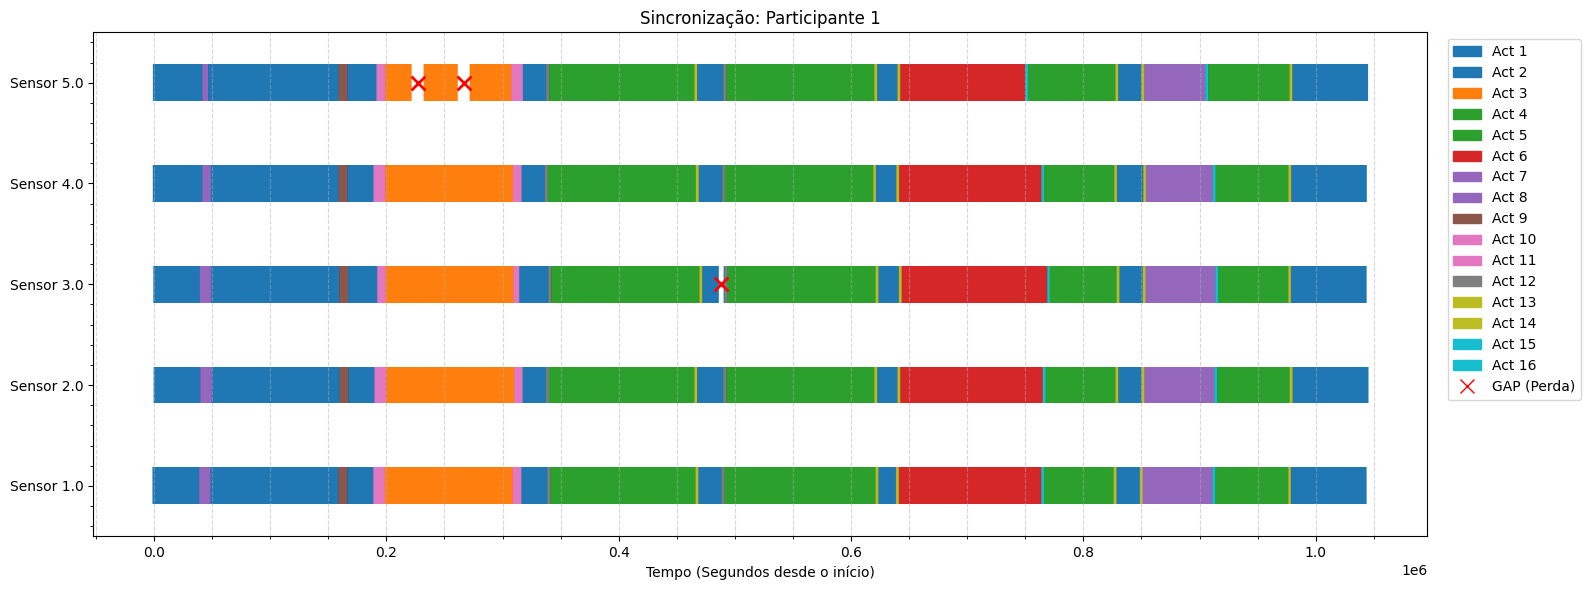

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def visualize_sync_gaps_seconds(df, participant_id, gap_threshold=1.0, limit_seconds=None):
    """
    Visualiza sincronização com tempo em SEGUNDOS (0, 1, 2...).
    Marca explicitamente GAPS (falhas de dados) com um 'X' vermelho.
    """
    # 1. Copiar e Filtrar
    df_plot = df[df['participant_id'] == participant_id].copy()
    
    if 'actitivy_label' in df_plot.columns:
        df_plot.rename(columns={'actitivy_label': 'activity_label'}, inplace=True)
        
    if df_plot.empty:
        print(f"Participante {participant_id} não encontrado.")
        return

    # Ordenar rigorosamente por tempo para calcular gaps
    df_plot.sort_values(['device_id', 'timestamp'], inplace=True)

    # 2. Converter Timestamp para SEGUNDOS RELATIVOS (t0 = 0)
    start_time = df_plot['timestamp'].min()
    df_plot['seconds'] = df_plot['timestamp'] - start_time
    
    # Filtro opcional para teste (ex: ver só os primeiros 60s)
    if limit_seconds:
        df_plot = df_plot[df_plot['seconds'] <= limit_seconds]

    print(f"A processar {len(df_plot)} pontos... (Tempo em segundos)")

    # 3. Configurar Cores das Atividades
    unique_acts = np.sort(df_plot['activity_label'].unique())
    cmap = plt.get_cmap('tab10', max(len(unique_acts), 1))
    act_to_color = {act: cmap(i) for i, act in enumerate(unique_acts)}
    
    # Atribuir cor a cada linha
    colors = df_plot['activity_label'].map(act_to_color)

    # 4. Desenhar
    fig, ax = plt.subplots(figsize=(16, 6))

    # --- CAMADA 1: DADOS (O "Traço") ---
    # Usamos o marker '|' para parecer uma fita contínua
    ax.scatter(
        df_plot['seconds'], 
        df_plot['device_id'], 
        c=colors, 
        marker='|', 
        s=700,         # Tamanho grande para fazer uma linha grossa
        alpha=0.9,
        label='Dados'
    )

    # --- CAMADA 2: GAPS (Os "X") ---
    # Vamos detetar onde o tempo saltou mais do que o permitido (ex: 1 segundo)
    # Fazemos isto por dispositivo para não confundir saltos entre sensores diferentes
    
    gap_x = []
    gap_y = []
    
    for dev_id in df_plot['device_id'].unique():
        dev_data = df_plot[df_plot['device_id'] == dev_id]
        
        # Calcular a diferença de tempo entre linhas consecutivas
        # shift(1) pega a linha anterior
        time_diff = dev_data['seconds'].diff()
        
        # Onde a diferença for maior que o threshold, temos um GAP
        gaps = dev_data[time_diff > gap_threshold]
        
        if not gaps.empty:
            # Marcamos o X um pouco antes do ponto de retoma
            # (no meio do buraco visual)
            gap_times = gaps['seconds'] - (time_diff[gaps.index] / 2)
            gap_x.extend(gap_times)
            gap_y.extend([dev_id] * len(gap_times))

    if gap_x:
        ax.scatter(
            gap_x, 
            gap_y, 
            color='red', 
            marker='x', 
            s=100, 
            linewidths=2, 
            zorder=10, # Garantir que fica por cima de tudo
            label='Gap Detectado'
        )
        print(f"⚠️ Detetados {len(gap_x)} locais com perda de dados (Gaps > {gap_threshold}s)")

    # 5. Cosmética
    devices = sorted(df_plot['device_id'].unique())
    ax.set_yticks(devices)
    ax.set_yticklabels([f"Sensor {d}" for d in devices])
    ax.set_ylim(min(devices) - 0.5, max(devices) + 0.5)
    
    ax.set_xlabel("Tempo (Segundos desde o início)")
    ax.set_title(f"Sincronização: Participante {participant_id}")
    
    # Grid vertical para ajudar a alinhar o olho
    ax.grid(True, axis='x', which='both', linestyle='--', alpha=0.5)
    ax.minorticks_on() # Adiciona ticks pequenos para precisão

    # Legenda Personalizada
    patches = [mpatches.Patch(color=act_to_color[a], label=f"Act {int(a)}") for a in unique_acts]
    # Adicionar o X à legenda
    patches.append(plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='red', markersize=10, markeredgecolor='red', label='GAP (Perda)'))
    
    ax.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# --- COMO USAR ---
# gap_threshold=1.0 -> Marca um X se o sensor ficar mudo por mais de 1 segundo
# limit_seconds=120 -> Mostra apenas os primeiros 2 minutos
visualize_sync_gaps_seconds(dataset, participant_id=1, gap_threshold=100.0)

In [ ]:
visualize_sync_gaps_seconds(dataset, participant_id=2, gap_threshold=100.0)

# extracted features analysis 

In [1]:
import pandas as pd
features=pd.read_csv('X_final_550.csv')

In [2]:
features.describe()

,Unnamed: 0,participant_id,window_id,S1_acc_array__mi_intensity__avg,S2_acc_array__mi_intensity__avg,S3_acc_array__mi_intensity__avg,S4_acc_array__mi_intensity__avg,S5_acc_array__mi_intensity__avg,S1_acc_array__mi_intensity__var,S2_acc_array__mi_intensity__var,...,S2_gyroscope_z__dominant_frequency_axis,S3_gyroscope_z__dominant_frequency_axis,S4_gyroscope_z__dominant_frequency_axis,S5_gyroscope_z__dominant_frequency_axis,S1_gyroscope_z__energy_axis,S2_gyroscope_z__energy_axis,S3_gyroscope_z__energy_axis,S4_gyroscope_z__energy_axis,S5_gyroscope_z__energy_axis,activity
count,12337.00000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,...,12337.000000,12337.000000,12337.000000,12337.000000,1.233700e+04,1.233700e+04,1.233700e+04,1.233700e+04,1.233700e+04,12337.000000
mean,6168.00000,7.024398,439.765097,10.049631,10.184828,9.969575,10.153959,10.633192,1.839669,1.788844,...,2.947313,3.418821,4.527681,4.414688,1.067684e+07,8.829197e+06,2.990555e+05,2.274439e+06,3.355710e+07,3.738429
std,3561.52947,4.513397,262.487264,0.249701,0.225029,0.120696,0.281531,1.007438,2.989221,2.691357,...,3.345678,4.974114,6.162446,6.053228,1.488203e+07,1.191787e+07,4.363042e+05,3.174193e+06,3.831167e+07,1.981614
min,0.00000,0.000000,0.000000,9.338126,9.555760,9.297977,9.516458,9.420257,0.000049,0.000066,...,1.000000,1.000000,1.000000,1.000000,3.170396e+01,4.427265e+01,1.078656e+02,3.725227e+01,3.857636e+01,1.000000
25%,3084.00000,3.000000,212.000000,9.862848,9.999734,9.905521,9.969539,9.741377,0.001069,0.001289,...,1.000000,1.000000,1.000000,2.000000,1.207642e+03,1.309510e+03,1.130847e+03,1.615443e+02,2.383019e+02,2.000000
50%,6168.00000,7.000000,432.000000,9.966850,10.134619,9.964401,10.032946,10.422058,0.888034,0.942372,...,2.000000,2.000000,2.000000,3.000000,4.122703e+06,3.428640e+06,1.500866e+05,1.018728e+06,2.135741e+07,4.000000
75%,9252.00000,11.000000,666.000000,10.167439,10.291537,10.022777,10.320066,11.338495,2.564930,2.636286,...,3.000000,3.000000,5.000000,4.000000,1.727756e+07,1.480721e+07,4.230579e+05,3.526237e+06,6.024738e+07,5.000000
max,12336.00000,14.000000,937.000000,12.132643,11.794771,10.828992,11.995472,15.130820,35.265814,28.338887,...,51.000000,36.000000,51.000000,51.000000,2.575748e+08,1.865278e+08,5.341692e+06,2.686971e+07,1.731247e+08,13.000000


In [10]:
from config.constants import ACTIVITY_LABELS


contagem = features['activity'].value_counts().sort_index()
percentagem = features['activity'].value_counts(normalize=True).sort_index() * 100

# 2. Converter índices para INTEIROS (corrige o TypeError)
ids = contagem.index.astype(int)

# 3. Criar a tabela incluindo o ID
resumo = pd.DataFrame({
    'ID': ids,                            # <--- Coluna ID mantida
    'Atividade': [ACTIVITY_LABELS[i] for i in ids],
    'Total Janelas': contagem.values,
    'Percentagem (%)': percentagem.values.round(2)
})
resumo

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


# Fase 2 


C:\Users\kille\AppData\Local\Temp\ipykernel_1092\70094376.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_viz, x='participant_id', y='accelerometer_y', ax=axes[0], palette="Set2")
C:\Users\kille\AppData\Local\Temp\ipykernel_1092\70094376.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_viz, x='participant_id', y='accelerometer_module', ax=axes[1], palette="Set2")


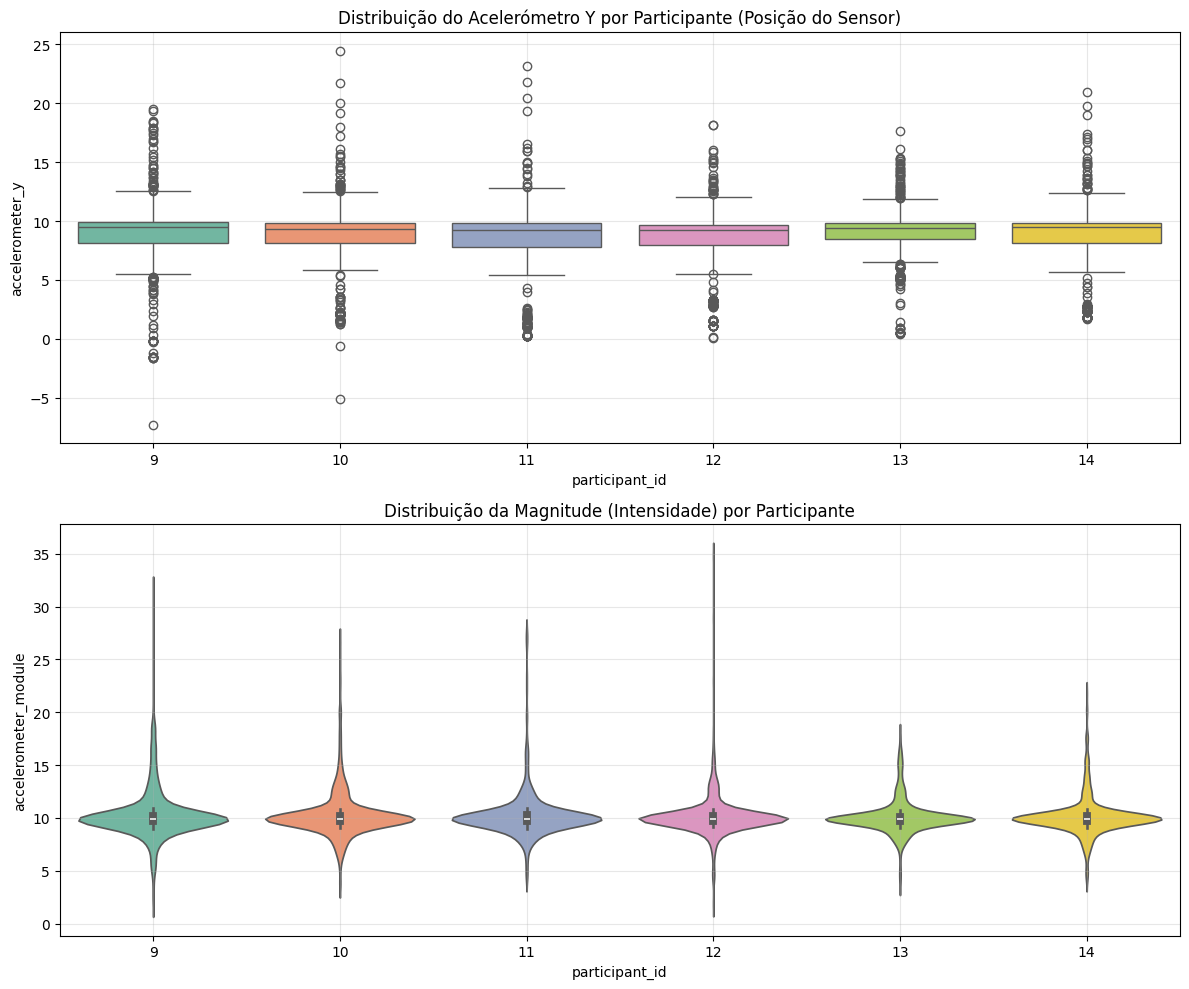

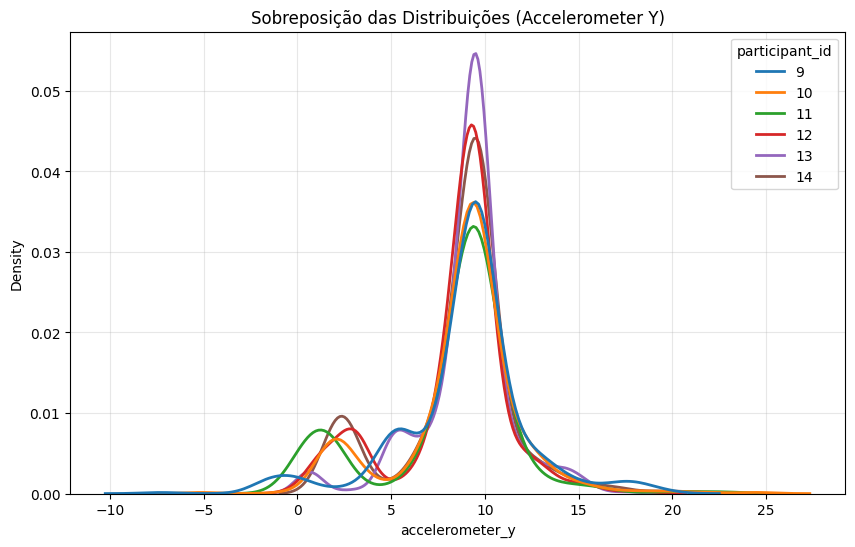

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ==============================================================================
# 1. PREPARAÇÃO
# ==============================================================================
# Vamos selecionar apenas alguns participantes para o gráfico não ficar ilegível
# Se tiveres 30, escolhe apenas os primeiros 5 ou 6 para a demonstração
n_participants_to_show = 6 
selected_subs = dataset['participant_id'].unique()[:n_participants_to_show]

df_viz = dataset[dataset['participant_id'].isin(selected_subs)].sample(n=3000, random_state=42)

# ==============================================================================
# 2. BOXPLOT: A Prova dos 9 (Shift de Média e Variância)
# ==============================================================================
# Vamos analisar o Eixo Y (frequentemente o mais afetado pela gravidade/bolso)
# e a Magnitude (Module) para ver a intensidade.

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico 1: Acelerómetro Y (Sensível a rotação/posição)
sns.boxplot(data=df_viz, x='participant_id', y='accelerometer_y', ax=axes[0], palette="Set2")
axes[0].set_title('Distribuição do Acelerómetro Y por Participante (Posição do Sensor)')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Magnitude (Intensidade do Movimento)
# Se usares violinplot vês também a "forma" da distribuição
sns.violinplot(data=df_viz, x='participant_id', y='accelerometer_module', ax=axes[1], palette="Set2")
axes[1].set_title('Distribuição da Magnitude (Intensidade) por Participante')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================================================
# 3. KDE PLOT (Densidade Sobreposta)
# ==============================================================================
# Para veres visualmente o "desalinhamento" das curvas
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_viz, x='accelerometer_y', hue='participant_id', fill=False, linewidth=2, palette="tab10")
plt.title("Sobreposição das Distribuições (Accelerometer Y)")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

label_mapping = {i: label for i, label in enumerate(ACRONYM_LABELS)}

# Preparar amostra
cols = ['accelerometer_module', 'gyroscope_module', 'magnetometer_module', 'actitivy_label']
subset = dataset[cols].sample(n=10000, random_state=42).copy()
subset['actitivy_label'] = subset['actitivy_label'].map(label_mapping)

# --- ESTRATÉGIA: DEFINIR GRUPOS ---
static_acts = ["STD", "SIT", "SIT-T"]
dynamic_acts = ["WLK", "WLK-T", "STR", "STR-T"]

# Filtros
df_static = subset[subset['actitivy_label'].isin(static_acts)]
df_dynamic = subset[subset['actitivy_label'].isin(dynamic_acts)]

# --- GRÁFICO 1: ESTÁTICOS (Onde o sensor quase não mexe) ---
plt.figure(figsize=(10, 8))
sns.pairplot(
    df_static,
    hue='actitivy_label',
    vars=['accelerometer_module', 'gyroscope_module', 'magnetometer_module'],
    palette='bright', # Cores vivas para distinguir
    plot_kws={'alpha': 0.5, 's': 20},
    diag_kind='kde',
    corner=True
)
plt.suptitle("Foco: Atividades Estáticas (STD, SIT)", y=1.02)
plt.show()

# --- GRÁFICO 2: DINÂMICOS (Onde há ação) ---
plt.figure(figsize=(10, 8))
sns.pairplot(
    df_dynamic,
    hue='actitivy_label',
    vars=['accelerometer_module', 'gyroscope_module', 'magnetometer_module'],
    palette='dark', # Cores mais escuras
    plot_kws={'alpha': 0.4, 's': 10},
    diag_kind='kde',
    corner=True
)
plt.suptitle("Foco: Atividades Dinâmicas (WLK, STR)", y=1.02)
plt.show()